In [3]:
import pandas as pd
import textwrap
import ftfy
from nltk import tokenize
from bert_serving.client import BertClient

# Transform original dataset

In [3]:
oc = pd.read_csv('tmp/opencorpora.csv.gz', compression='gzip')
criminal_code = pd.read_csv('tmp/vectors/criminal_code.csv.gz', compression='gzip')
criminal_court_orders = pd.read_csv('tmp/vectors/criminal_court_orders.csv.gz', compression='gzip')
civil_code = pd.read_csv('tmp/vectors/civil_code.csv.gz', compression='gzip')
civil_court_orders = pd.read_csv('tmp/vectors/civil_court_orders.csv.gz', compression='gzip')

oc['source'] = 'opencorpora'
criminal_code['source'] = 'criminal_code'
criminal_court_orders['source'] = 'criminal_court_orders'
civil_code['source'] = 'civil_code'
civil_court_orders['source'] = 'civil_court_orders'

criminal_code['name'] = criminal_code.apply(lambda x: "Ст.{} {}".format(x['article_number'], x['article_name']), axis=1)
civil_code['name'] = civil_code.apply(lambda x: "Ст.{} {}".format(x['article_number'], x['article_name']), axis=1)
civil_court_orders['name'] = ["Гражд. дело {}".format(i) for i in range(civil_court_orders.shape[0])]

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
tmp = pd.concat([
    oc.reset_index()[['index', 'title', 'lemmas', 'source']].rename(columns={'title':'name'}), 
    criminal_code.reset_index()[['index', 'name', 'lemmas', 'source']],#.rename(columns={"article": "text"}),
    criminal_court_orders.reset_index()[['index', 'title', 'lemmas',  'source']].rename(columns={'title':'name'}),
    civil_code.reset_index()[['index', 'name', 'lemmas', 'source']],#.rename(columns={"article": "text"}),
    civil_court_orders.reset_index()[['index', 'name', 'lemmas', 'source']],
]).reset_index(drop=True)

In [6]:
def fix_text(text):
    return ftfy.fix_text(" ".join(text.replace("\n", " ").replace("\r", " ").replace("\t", " ").split()))

In [5]:
#tmp['text'] = tmp['text'].map(fix_text)

In [9]:
tmp['sent'] = tmp['lemmas'].map(tokenize.sent_tokenize)

In [34]:
res = []
MAX_LEN = 50
MIN_LEN = 10

for i, data in tmp.iterrows():
    sentences = []
    
    for sent in data['sent']:
        if len(sent) > MIN_LEN:
            sentences += textwrap.wrap(sent, MAX_LEN)
            
    for sent in sentences:
        if len(sent) > MIN_LEN:
            res.append({
                "i": i,
                "name": data['name'],
                "source": data['source'],
                "sent": sent
            })

In [35]:
df = pd.DataFrame(res)

In [36]:
def tokenize(text):
    return f"[CLS] {text} [SEP]".split()

In [44]:
tmp['tokens'] = tmp['lemmas'].map(tokenize)

# Bert sentence embedding

In [45]:
tmp.shape[0]

31161

In [46]:
bc = BertClient(ip='localhost', check_length=False)

In [48]:
bert_embeddings = bc.encode(tmp['tokens'].tolist(), is_tokenized=True)

In [51]:
tmp['bert'] = bert_embeddings.tolist()

In [55]:
len(tmp['bert'][0])

768

In [56]:
tmp.to_csv("tmp_bert/bert_dataset.csv.gz", compression='gzip', index=False)

## visualize

In [78]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

/home/gzhigalov/miniconda3/envs/testing/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [59]:
tmp['bert_pca'] = PCA(n_components=2).fit_transform(tmp['bert'].tolist()).tolist()

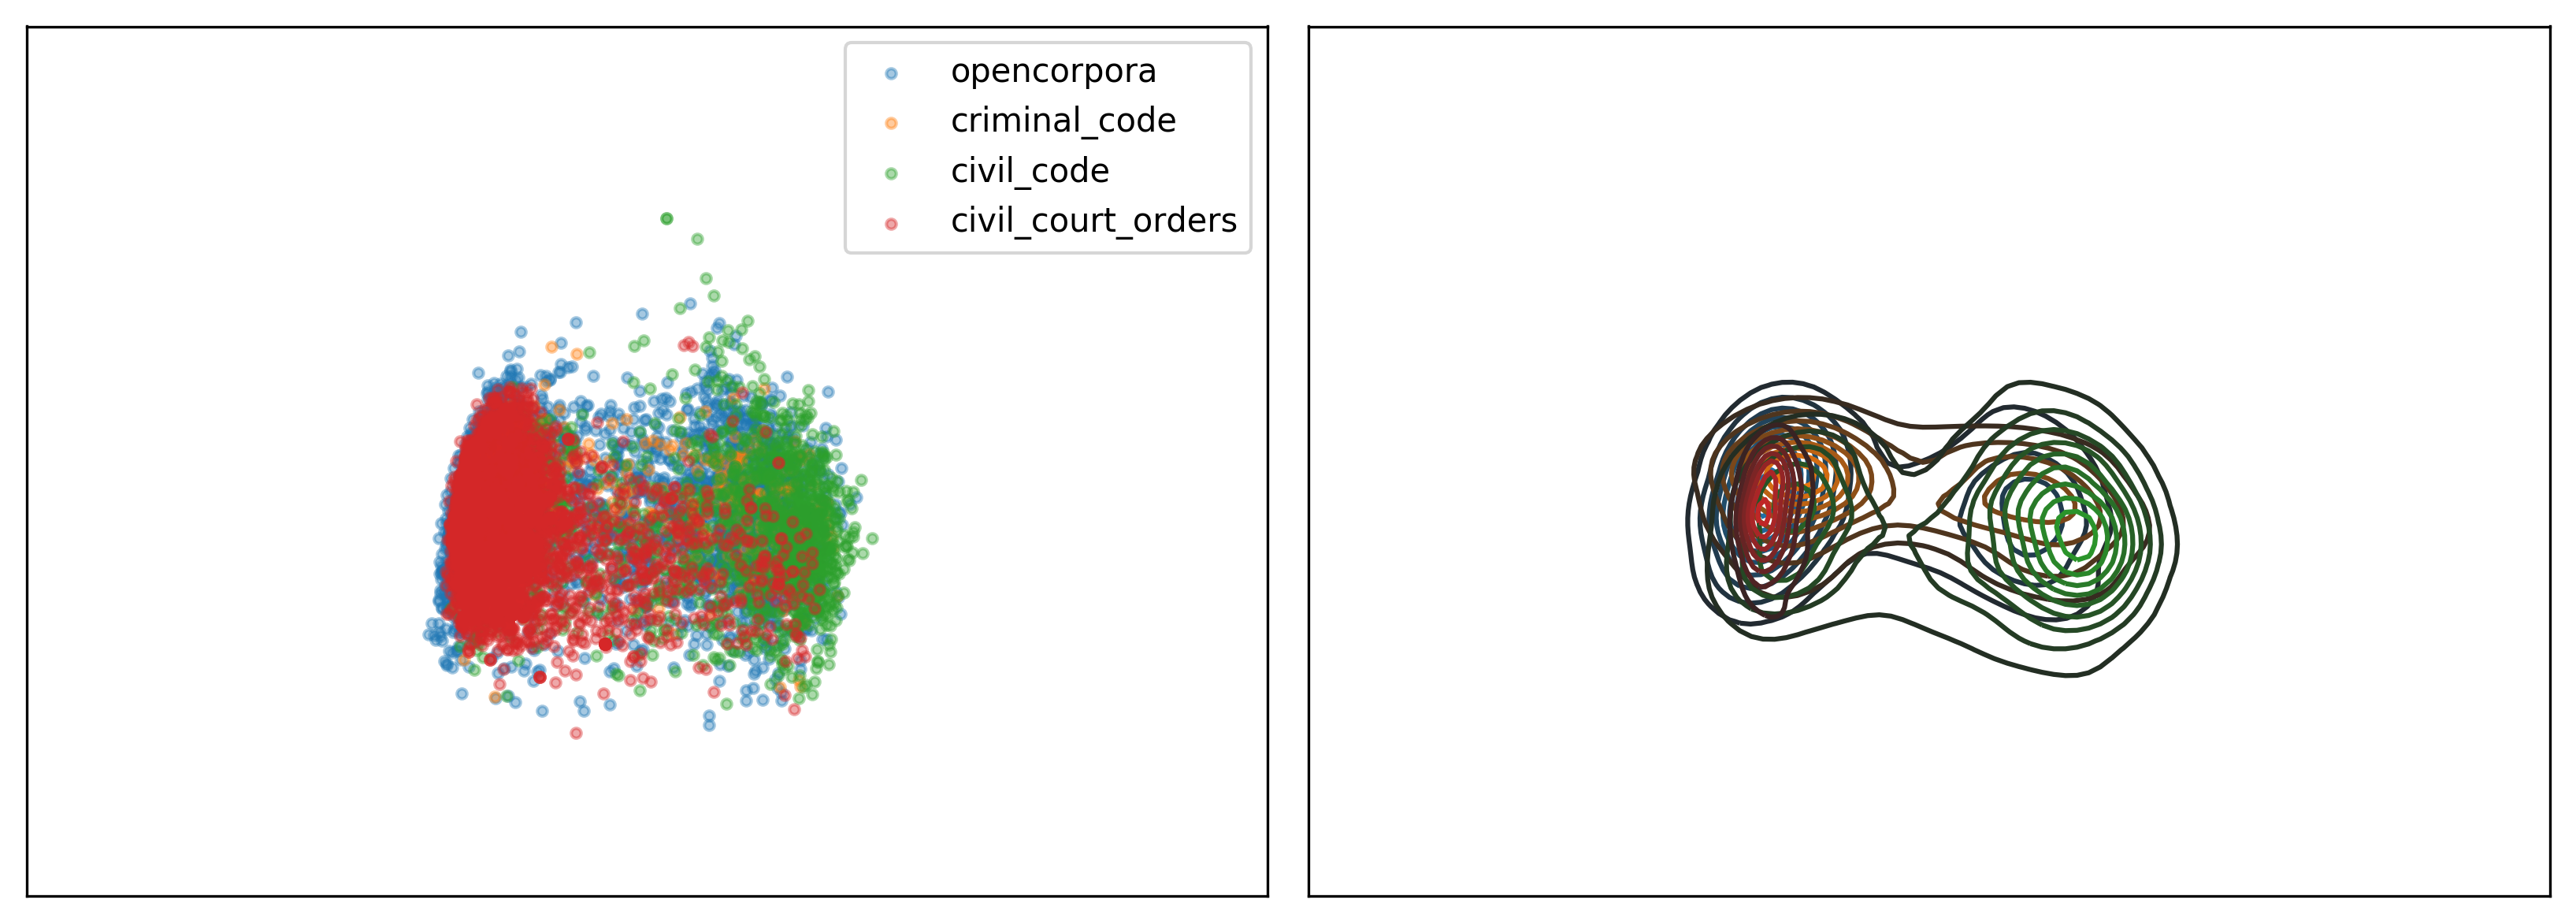

In [62]:
METHOD = 'bert_pca'#'tsne'
DISPLAY = ['civil_code', 'criminal_code', 'civil_court_orders', 'crim_court_orders', 'opencorpora']

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11, 4), dpi=300, sharex='all', sharey='all')

for source in tmp['source'].unique():
    if source in DISPLAY:
        t = np.array(tmp[tmp['source'] == source][METHOD].tolist())
        ax1.scatter(t[:, 0], t[:, 1], marker='.', label=source, alpha=.4)
        ax2 = sns.kdeplot(t[:, 0], t[:, 1], ax=ax2, legend=False, shade_lowest=False, cut=10)
        # ax2.text(-5, 8, "Court Orders", size=10, color='red')
    
ax1.legend()
ax1.tick_params(axis='both', which='both', left=False, bottom=False, labelleft=False, labelbottom=False)
ax2.tick_params(axis='both', which='both', left=False, bottom=False, labelleft=False, labelbottom=False)

plt.tight_layout()
plt.autoscale()
plt.show()

In [28]:
with open("tmp_bert/bert_ls.txt", "w") as writer:
    for x in df['sent'][:10000].tolist():
        writer.write(x + "\n")

In [24]:
import os
os.environ['http_proxy'] = "http://10.207.32.118:8080"
os.environ['https_proxy'] = "https://10.207.32.118:8080"
os.environ['HTTP_PROXY']="http://10.207.32.118:8080"
os.environ['HTTPS_PROXY']="https://10.207.32.118:8080"

In [30]:
%%time
!/home/gzhigalov/miniconda3/envs/bert/bin/python tmp_bert/pytorch-pretrained-BERT/examples/extract_features.py \
--input_file tmp_bert/bert_ls.txt \
--output_file tmp_bert/bert_res.txt \
--bert_model bert-base-multilingual-cased \
--max_seq_length 100 \
--batch_size 100 

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.
02/24/2019 09:16:28 - INFO - __main__ -   device: cuda n_gpu: 4 distributed training: False
02/24/2019 09:16:29 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-vocab.txt from cache at /home/gzhigalov/.pytorch_pretrained_bert/96435fa287fbf7e469185f1062386e05a075cadbf6838b74da22bf64b080bc32.99bcd55fc66f4f3360bc49ba472b940b8dcf223ea6a345deb969d607ca900729
02/24/2019 09:16:30 - INFO - __main__ -   *** Example ***
02/24/2019 09:16:30 - INFO - __main__ -   unique_id: 0
02/24/2019 09:16:30 - INFO - __main__ -   tokens: [CLS] « Школа з ##лос ##лов ##ия » учи ##т при ##ку ##сить язык Со ##х ##рани ##тся ли граду ##с диск ##ус ##сии в новом сезоне ? [SEP]
02/24/2019 09:16:30 - INFO - __main__ -   input_ids: 101 208 72030 548 105763 18359 11502 220 103510 10351 10913 11191 99366 29757 36852 10353 32229 

# Truncated dataset

In [57]:
df = pd.read_csv('labeled_texts.csv.gz', compression='gzip')
df = pd.concat([df[df['source'] == source][:100] for source in df['source'].unique()]).reset_index(drop=True)

In [58]:
res = []
MAX_LEN = 50
MIN_LEN = 10

for i, data in df.iterrows():
    sentences = []
    
    for sent in tokenize.sent_tokenize(data['text']):
        if len(sent) > MIN_LEN:
            sentences += textwrap.wrap(sent, MAX_LEN)
            
    for sent in sentences:
        if len(sent) > MIN_LEN:
            res.append({
                "i": i,
                "name": data['name'],
                "source": data['source'],
                "sent": sent
            })

In [61]:
df = pd.DataFrame(res)

In [63]:
bc = BertClient(ip='localhost', check_length=False)

In [65]:
df['sent'] = df['sent'].str.split()

In [ ]:
%%time 
bert_embeddings = bc.encode(df['sent'].tolist(), is_tokenized=True)

In [74]:
df['bert'] = bert_embeddings.tolist()

In [79]:
df['pca'] = PCA(n_components=2).fit_transform(df['bert'].tolist()).tolist()

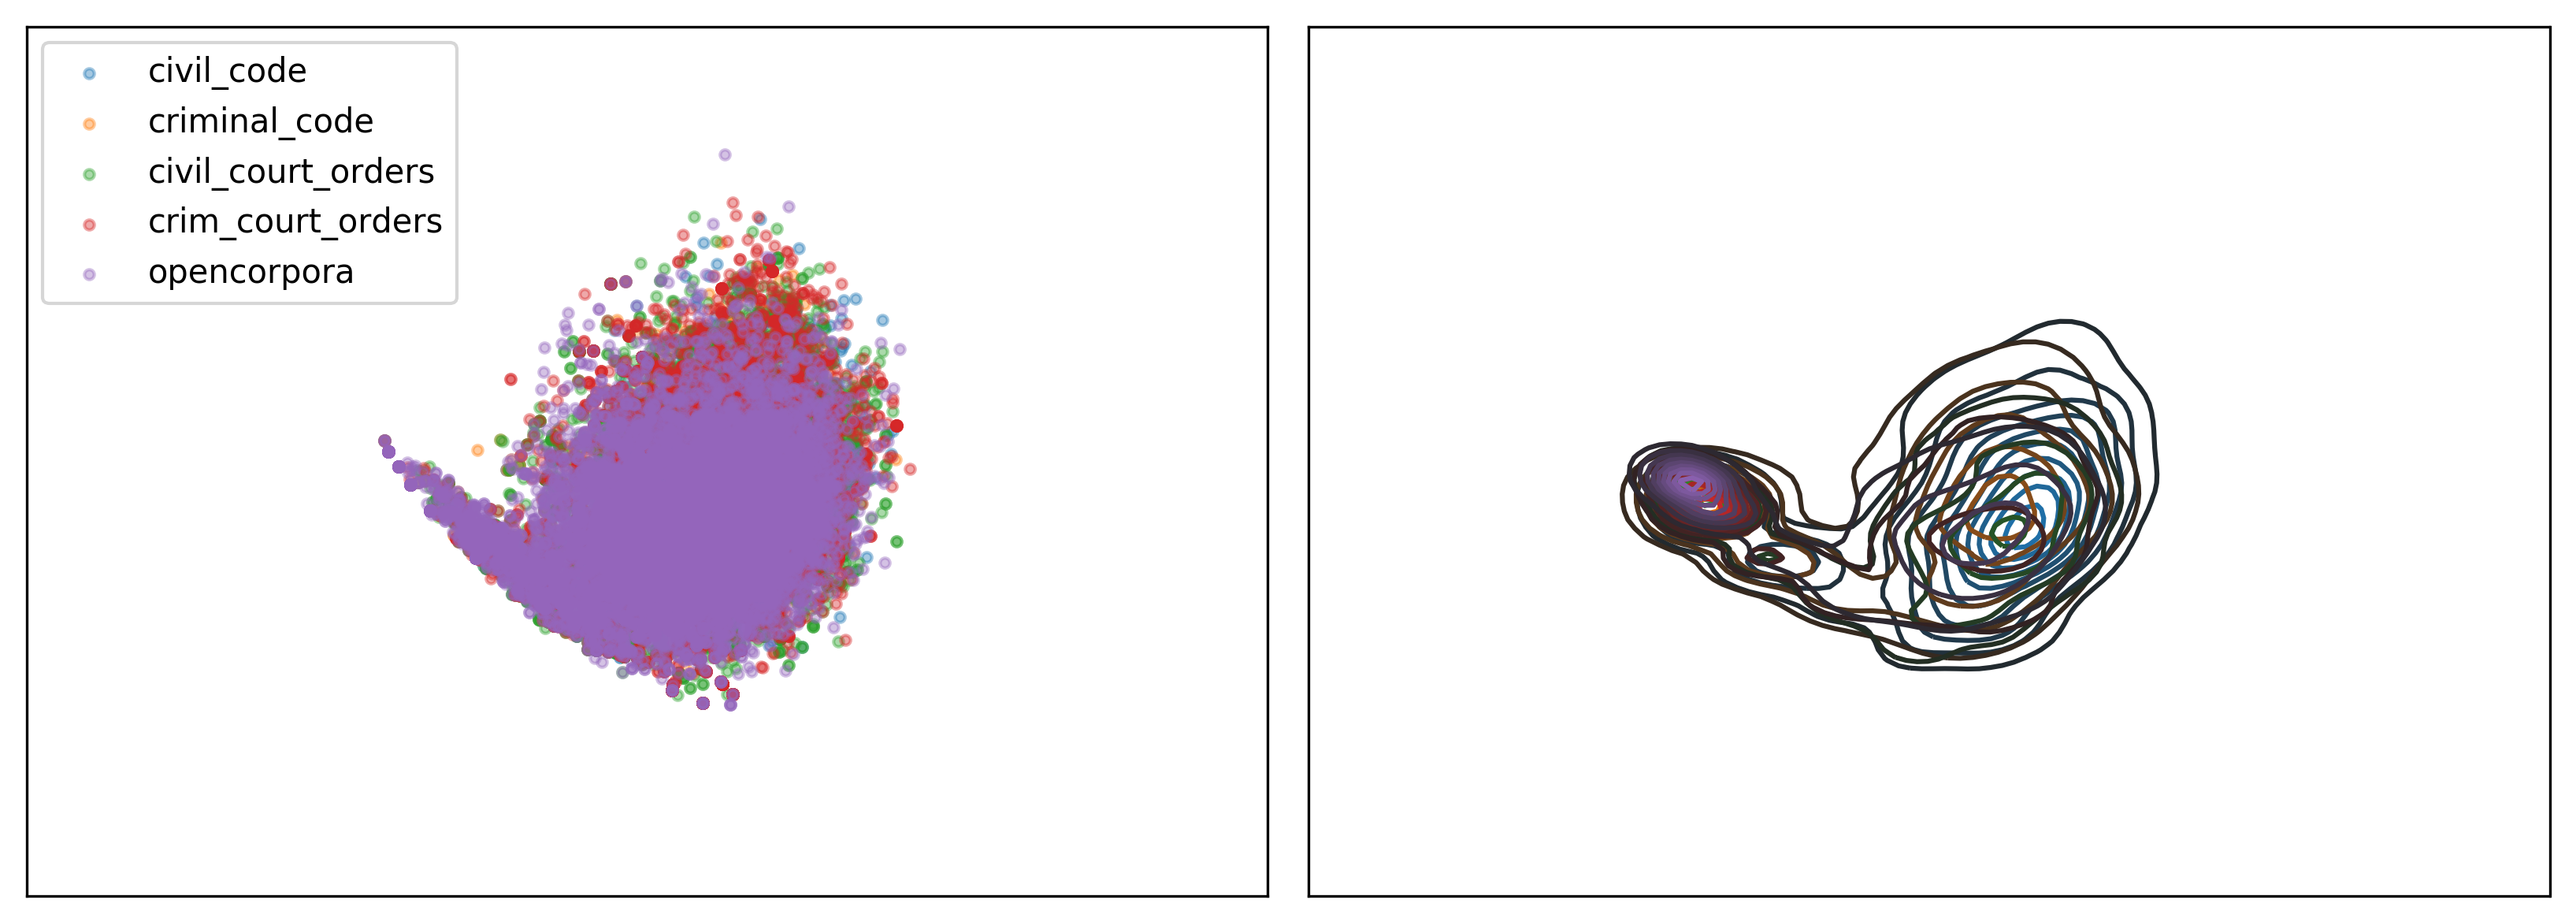

In [83]:
METHOD = "pca"
DISPLAY = df["source"].unique()

fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2, figsize=(11, 4), dpi=300, sharex="all", sharey="all"
)

for source in df["source"].unique():
    if source in DISPLAY:
        t = np.array(df[df["source"] == source][METHOD].tolist())
        ax1.scatter(t[:, 0], t[:, 1], marker=".", label=source, alpha=0.4)
        ax2 = sns.kdeplot(
            t[:, 0], t[:, 1], ax=ax2, legend=False, shade_lowest=False, cut=10
        )

ax1.legend()
ax1.tick_params(
    axis="both",
    which="both",
    left=False,
    bottom=False,
    labelleft=False,
    labelbottom=False,
)
ax2.tick_params(
    axis="both",
    which="both",
    left=False,
    bottom=False,
    labelleft=False,
    labelbottom=False,
)

plt.tight_layout()
plt.autoscale()
plt.show()


In [84]:
df.to_csv("tmp_bert/bert_100_result.csv.gz", compression='gzip', index=False)

## Original dataset

In [6]:
oc = pd.read_csv('tmp/opencorpora.csv.gz', compression='gzip')
criminal_code = pd.read_csv('tmp/vectors/criminal_code.csv.gz', compression='gzip')
criminal_court_orders = pd.read_csv('tmp/vectors/criminal_court_orders.csv.gz', compression='gzip')
civil_code = pd.read_csv('tmp/vectors/civil_code.csv.gz', compression='gzip')
civil_court_orders = pd.read_csv('tmp/vectors/civil_court_orders.csv.gz', compression='gzip')

oc['source'] = 'opencorpora'
criminal_code['source'] = 'criminal_code'
criminal_court_orders['source'] = 'criminal_court_orders'
civil_code['source'] = 'civil_code'
civil_court_orders['source'] = 'civil_court_orders'

criminal_code['name'] = criminal_code.apply(lambda x: "Ст.{} {}".format(x['article_number'], x['article_name']), axis=1)
civil_code['name'] = civil_code.apply(lambda x: "Ст.{} {}".format(x['article_number'], x['article_name']), axis=1)
civil_court_orders['name'] = ["Гражд. дело {}".format(i) for i in range(civil_court_orders.shape[0])]

In [11]:
criminal_court_orders

,vectors,pca,title,date,category,region,court,judge,intro,case,result,labels,lemmas,phrased,source
0,"[3.1667587757110596, -0.5775691270828247, 0.07...","[2.219553700422508, 2.6333611625081828]",Решение по делу 1-111/2018 - 318 ч.1 - судья К...,08.02.2018,318 ч.1 Применение насилия в отношении предста...,Нижегородская область,Канавинский районный суд г. Нижний Новгород (Н...,Кучин И. П.,дело (№) п р и г о в о р именем российской фед...,": (.) полицейский (данные обезличены), назначе...",: признать курмаева анатолия евгеньевича винов...,318.0 317.0,полицейский данные обезличивать назначать указ...,полицейский данные обезличивать назначать указ...,criminal_court_orders
1,"[-0.23159003257751465, -0.7754107713699341, 1....","[-1.5619511349124457, 1.4458834951281785]",Решение по делу 1-1/2018 (1-99/2017;) - 228 ч....,08.02.2018,"228 ч.1 Незаконные приобретение, хранение, пер...",Курганская область,Петуховский районный суд (Курганская область),Григорьева О. Б.,дело № 11/2018 приговор именем российской феде...,: шашков совершил незаконные изготовление и хр...,: шашкова н.в. признать виновным в совершении ...,228.0 317.0,шашков совершать незаконный изготовление хране...,шашков совершать незаконный_изготовление хране...,criminal_court_orders
2,"[-1.449013590812683, -1.7224146127700806, 1.45...","[4.301893789776654, 2.009720047670334]",Решение по делу 1-14/2018 - 115 ч.1 - судья Ка...,08.02.2018,115 ч.1 Умышленное причинение легкого вреда зд...,Республика Башкортостан,Судебный участок по Зианчуринскому району Респ...,Кагирова Фаиля Рафисовна,№ 114/2018 приговор именем российской федераци...,": аккужина , умышленно совершила преступление...",: аккужину признать виновной в совершении пр...,115.0,аккужин умышленно совершать преступление преду...,аккужин умышленно совершать преступление преду...,criminal_court_orders
3,"[0.5599213242530823, 0.1043134555220604, -0.99...","[-2.5459934131058826, 1.6005407904514217]",Решение по делу 1-90/2018 - 228 ч.1 - судья Ко...,08.02.2018,"228 ч.1 Незаконные приобретение, хранение, пер...",Приморский край,Артемовский городской суд (Приморский край),Корчагина Ольга Васильевна,№ 1 90/2018 год п р и г о в о р именем российс...,": евдаков в.п., достоверно зная, что на террит...",: евдакова в.п. признать виновным в совершени...,228.0 73.0,евдаков достоверно знать территория запрещать ...,евдаков достоверно_знать территория запрещать ...,criminal_court_orders
4,"[-0.2888224422931671, -1.2456945180892944, 1.4...","[-0.2093965041802813, -3.186838978557407]","Решение по делу 1-13/2018 - 158 ч.2 п.п.а,в - ...",08.02.2018,"158 ч.2 п.п.а,в Кража",Республика Адыгея,Майкопский районный суд (Республика Адыгея),Дарзиян Альберт Артюшевич,к делу № приговор именем российской федерации ...,: бенда геннадий васильевич и цыбуленко алексе...,: признать бенда геннадия васильевича виновн...,158.0 158.0,бенда геннадий васильевич цыбуленко алексей ни...,бенда геннадий васильевич цыбуленко алексей_ни...,criminal_court_orders
5,"[-0.9448865652084351, 0.19357454776763916, 1.5...","[-1.684723373715602, -0.10304313652801982]",Решение по делу 1-24/2018 - 175 ч.1; 238 ч.1 -...,08.02.2018,175 ч.1; 238 ч.1 Приобретение или сбыт имущест...,Республика Дагестан,Дербентский районный суд (Республика Дагестан),Ахмедова Сакинат Мустафаевна,п р и г о в о р именем российской федерации 08...,: казиев а.с. совершил заранее не обещанный сб...,: казиева адиля салахаддиновича признать винов...,175.0 238.0 175.0 238.0 69.0 317.0,казиев совершать заранее обещать сбыт имуществ...,казиев совершать заранее_обещать сбыт имуществ...,criminal_court_orders
6,"[0.049937859177589417, 1.9530694484710693, -0....","[0.4526473151297933, -5.107732096583376]",Решение по делу 1-30/2018 - 119 ч.1; 158 ч.2 п...,08.02.2018,"119 ч.1; 158 ч.2 п.п.а,б,в Угроза убийством ил...",Кировская область,Котельничский районный суд (Кировская область),Колотовкин Павел Владимирович,дело № 130/2018 (11701330004000259) п р и г о ...,": малён а.в. и цепелев п.б. совершили кражу, т...",: призна

In [5]:
tmp = pd.concat([
    oc.reset_index()[['index', 'title', 'text', 'source']].rename(columns={'title':'name'}), 
    criminal_code.reset_index()[['index', 'name', 'article', 'source']].rename(columns={"article": "text"}),
    criminal_court_orders.reset_index()[['index', 'title', 'lemmas',  'source']].rename(columns={'title':'name'}),
    civil_code.reset_index()[['index', 'name', 'lemmas', 'source']],#.rename(columns={"article": "text"}),
    civil_court_orders.reset_index()[['index', 'name', 'lemmas', 'source']],
]).reset_index(drop=True)

,name,number,text,source
0,Основные начала гражданского законодательства,1.0,гражданский законодательство основываться приз...,civil_code
1,"Отношения, регулируемые гражданским законодате...",2.0,гражданский законодательство определять правов...,civil_code
2,"Гражданское законодательство и иные акты, соде...",3.0,соответствие конституция российский федерация ...,civil_code
3,Действие гражданского законодательства во времени,4.0,акт гражданский законодательство обратный сила...,civil_code
4,Обычаи,5.0,обычай признаваться складываться широко примен...,civil_code
5,Применение гражданского законодательства по ан...,6.0,случай предусматривать пункт статья настоящий ...,civil_code
6,Основания возникновения гражданских прав и обя...,8.0,гражданский право обязанность возникать основа...,civil_code
7,Государственная регистрация прав на имущество,8.1,случай предусматривать закон право закреплять ...,civil_code
8,Осуществление гражданских прав,9.0,гражданин юридический лицо свой усмотрение осу...,civil_code
9,Пределы осуществления гражданских прав,10.0,допускаться осуществление гражданский право ис...,civil_code
